In [4]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import fiona
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import box


### Load data

In [9]:
dir_path = '../data/external/water_stations_data/water_temp'
#dir_path = '../../tfg/data/15994_4699_2024-10-31_11-54-16'
stations_meta = pd.read_excel('../data/external/Stationsliste_HydrowebSAM_EN_july2023.xlsx',skiprows=range(0,4))
stations_meta.rename(columns={'Station number': 'Stationsnummer'}, inplace=True)
stations_meta.drop_duplicates(subset = ['Stationsnummer'], inplace=True)

### Obtain georeference about stations that have data

In [33]:
stations_ds={}
new_df = pd.DataFrame()
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file), delimiter=';', encoding='latin1', skiprows=range(0,8))
        st_number = df.Stationsnummer.unique()
        st_number_str = st_number[0]
        
        if len(st_number) > 1:
            i = 1
            while st_number_str == 'Stationsnummer' or np.isnan(float(st_number_str)):
                st_number_str = st_number[i]
                i+=1
            print('More than one station number')
        print(st_number_str)
        if st_number_str in stations_meta['Stationsnummer'].values:
            print('Station number found')
            new_df = pd.concat([new_df,stations_meta[stations_meta['Stationsnummer']==st_number_str]])
            
        d = "2013-03-01"
        #df["Zeitstempel"] = pd.to_datetime(df["Zeitstempel"])
        df = df[df.Zeitstempel >= d]
        stations_ds[st_number_str] = df
            

2016
Station number found
2347
Station number found
2269
Station number found
2033
Station number found
2070
Station number found
2130
Station number found
2609
Station number found
2410
Station number found
2174
Station number found
2018
Station number found
2029
Station number found
2276
Station number found
2481
Station number found
2044
Station number found
2091
Station number found
2019
Station number found
2135
Station number found
2392
Station number found
2635
Station number found
2143
Station number found
2243
Station number found
2085
Station number found
2084
Station number found
2112
Station number found
2232
Station number found
2011
Station number found
2327
Station number found
2009
Station number found
2623
Station number found
2106
Station number found
2150
Station number found
2343
Station number found
2179
Station number found
2617
Station number found
2068
Station number found
2282
Station number found
2351
Station number found
2369
Station number found
2433
Station

In [35]:
stations_ds[2161]

,Stationsname,Stationsnummer,Parameter,Zeitreihe,Parametereinheit,Gewässer,Zeitstempel,Zeitpunkt_des_Auftretens,Wert,Freigabestatus
2,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2013-03-01 00:00:00,NaN,0.96,"Freigegeben, validierte Daten"
3,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2013-04-01 00:00:00,NaN,1.56,"Freigegeben, validierte Daten"
4,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2013-05-01 00:00:00,NaN,1.31,"Freigegeben, validierte Daten"
5,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2013-06-01 00:00:00,NaN,1.31,"Freigegeben, validierte Daten"
6,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2013-07-01 00:00:00,NaN,1.25,"Freigegeben, validierte Daten"
...,...,...,...,...,...,...,...,...,...,...
136,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2024-05-01 00:00:00,NaN,1.79,"Freigegeben, geprüfte Daten"
137,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2024-06-01 00:00:00,NaN,1.56,"Freigegeben, geprüfte Daten"
138,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2024-07-01 00:00:00,NaN,Lücke,"Nicht freigegeben, Rohdaten"
139,Blatten bei Naters,2161,Wassertemperatur,Monatsmittel,°C,Massa,2024-08-01 00:00:00,NaN,223.36,"Nicht freigegeben, Rohdaten"


### Obtain grid cells sorrounding every station

In [13]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")


<Axes: >

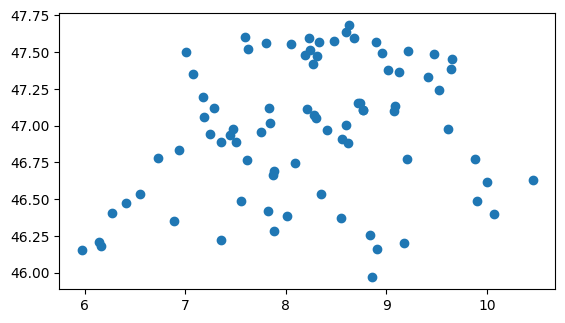

In [14]:
gdf.plot()

In [48]:
water_ds = pd.DataFrame(index = stations_ds[2161].Zeitstempel,columns = range(1,len(gdf)+1))

#### Create a shp for each cell

In [52]:
# Change the CRS to a projected coordinate system (e.g., UTM appropriate for your region)
gdf = gdf.to_crs("EPSG:32633")  # Make sure to use the correct CRS for your region

# Define the buffer size in meters (10x10 km = 5000 m in each direction from the center point)
buffer_size = 5000

# Create a folder to store the shapefiles if it doesn't exist
output_folder = "../data/external/shp/cells_10x10km"
os.makedirs(output_folder, exist_ok=True)

c=1
# Iterate over each point and create a 10x10 km cell, saving it as an individual shapefile
for idx, point in gdf.iterrows():
    # Create the square cell
    x, y = point.geometry.x, point.geometry.y
    square = box(x - buffer_size, y - buffer_size, x + buffer_size, y + buffer_size)
    
    # Create a new GeoDataFrame for the cell
    cell_gdf = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[square])
    
    # Define the filename for each cell, using the index or any relevant attribute
    cell_filename = f"{output_folder}/cell_{c}.shp"
    cell_gdf = cell_gdf.to_crs("EPSG:2056")
    
    # Save the individual cell as a shapefile
    cell_gdf.to_file(cell_filename, driver="ESRI Shapefile")
    try:
        station_number = point.Stationsnummer
        station_data = stations_ds[station_number]
        water_ds[c] = list(station_data.Wert.values)
    except:
        print(station_number,c, len(list(station_data.Wert.values)))
    
    
    c+=1
    

print("Individual shapefiles created in the 'cells_10x10km' folder.")


guardo 1
guardo 2
guardo 3
guardo 4
guardo 5
guardo 6
guardo 7
guardo 8
guardo 9
guardo 10
guardo 11
guardo 12
guardo 13
guardo 14
guardo 15
guardo 16
guardo 17
guardo 18
guardo 19
guardo 20
guardo 21
guardo 22
guardo 23
guardo 24
guardo 25
guardo 26
guardo 27
guardo 28
guardo 29
guardo 30
guardo 31
guardo 32
guardo 33
guardo 34
guardo 35
guardo 36
guardo 37
guardo 38
guardo 39
guardo 40
guardo 41
guardo 42
guardo 43
guardo 44
guardo 45
guardo 46
guardo 47
guardo 48
guardo 49
guardo 50
guardo 51
guardo 52
guardo 53
guardo 54
guardo 55
guardo 56
guardo 57
guardo 58
guardo 59
guardo 60
guardo 61
guardo 62
guardo 63
guardo 64
guardo 65
guardo 66
guardo 67
guardo 68
guardo 69
guardo 70
2356 70 138
guardo 71
guardo 72
guardo 73
guardo 74
guardo 75
guardo 76
guardo 77
guardo 78
guardo 79
guardo 80
guardo 81
Individual shapefiles created in the 'cells_10x10km' folder.


In [67]:
dirr='../data/raw/wt'
os.makedirs(dirr,exist_ok=True)
water_ds.to_csv(f'{dirr}/water_temp.csv',index=True)
pd.read_csv(f'{dirr}/water_temp.csv', index_col=0)

,1,2,3,4,5,6,7,8,9,10,...,72,73,74,75,76,77,78,79,80,81
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,5.76,1.05,2.72,2.91,3.61,5.86,3.23,7.46,6.24,5.59,...,5.96,8.20,4.04,6.69,6.04,6.06,5.48,3.83,4.64,0.96
2013-04-01 00:00:00,8.16,3.23,3.62,5.43,5.91,8.54,5.20,8.94,8.94,8.33,...,8.02,9.92,5.92,9.93,8.77,8.77,8.22,8.19,8.90,1.56
2013-05-01 00:00:00,12.06,5.38,4.49,6.83,8.68,12.21,8.49,9.46,10.16,11.65,...,8.53,10.93,6.86,13.71,10.15,12.35,10.14,10.75,11.26,1.31
2013-06-01 00:00:00,15.15,9.05,5.01,8.56,12.00,15.21,12.85,10.42,13.67,15.12,...,10.90,12.93,8.49,17.17,14.04,15.36,13.41,13.63,15.18,1.31
2013-07-01 00:00:00,19.52,12.63,6.34,10.80,15.42,21.28,17.35,11.98,19.61,20.50,...,13.75,16.97,10.80,20.67,20.99,21.30,17.45,17.22,20.13,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,13.94,6.03,4.81,7.26,10.67,13.85,11.10,10.58,12.20,13.40,...,10.36,12.10,7.63,15.62,12.29,13.95,11.97,12.41,14.02,1.79
2024-06-01 00:00:00,16.58,9.45,5.38,8.63,13.05,17.00,13.57,11.62,15.24,16.79,...,12.24,13.55,9.03,18.39,15.95,17.04,14.46,14.65,16.51,1.56
2024-07-01 00:00:00,19.75,12.10,6.82,10.47,15.52,20.68,16.94,12.39,18.90,20.38,...,14.30,15.95,10.74,20.82,19.92,20.67,17.49,17.22,19.97,Lücke


<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

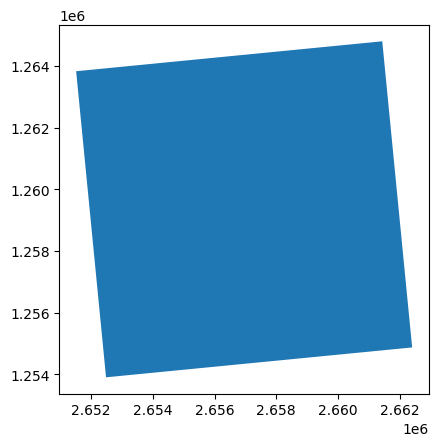

In [68]:
a=gpd.read_file(os.path.join(output_folder,'cell_1.shp'))
a.plot()
a.crs

#### Plot all cells

<Axes: >

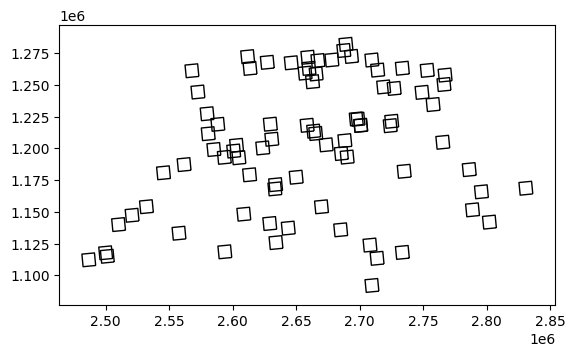

In [69]:
gdf = gdf.to_crs("EPSG:32633")
buffer_size = 5000  # 10x10 km significa 5 km de radio en cada dirección desde el centro

# Función para crear una celda cuadrada alrededor de cada punto
def create_square(point, size):
    x, y = point.x, point.y
    return box(x - size, y - size, x + size, y + size)

# Aplicamos la función a cada punto en el GeoDataFrame
gdf['geometry'] = gdf.geometry.apply(lambda point: create_square(point, buffer_size))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(color='none')

### Comparison to old cells

In [70]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'Switzerland_shapefile': 'ch_1km' (default), 'ch_10km', 'ch_100km'. Specify layer parameter to avoid this warning.
  result = read_func(


<Axes: >

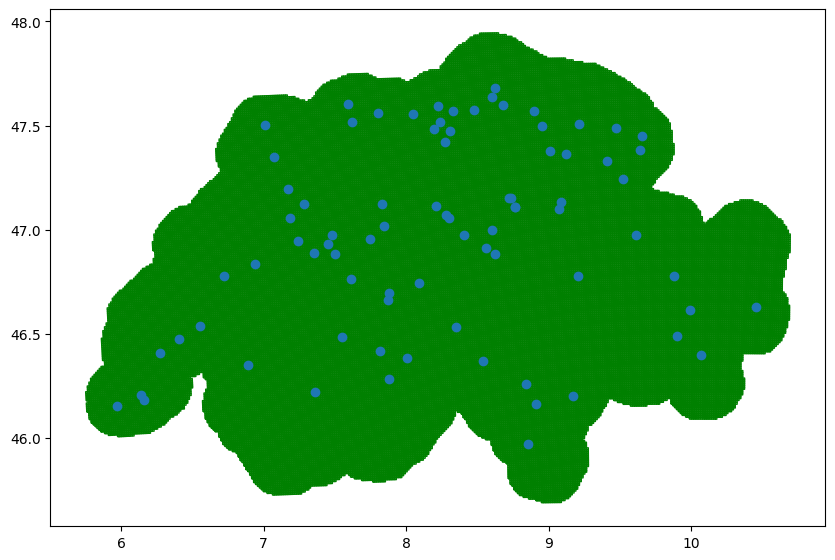

In [71]:
gdf2 = gpd.read_file('../data/external/shp/Switzerland_shapefile')
gdf2 = gdf2.to_crs("EPSG:4326")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf2.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=1, label='Preprocessed Cells')
gdf.plot(ax=ax)
